In [1]:
import pandas as pd
import numpy as np 
import io

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import clear_output


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import accuracy_score
from sklearn import linear_model

# Important Functions 

In [2]:
np.append(np.zeros(2),[1,2])

array([0., 0., 1., 2.])

In [3]:
def stacking(groups, padding = 'left'):
    X_group = np.empty(shape=[0, max_length])
    y_group = np.empty(shape=[0, 2])
    for i in range(len(groups)):
        hash_ = np.array([[]])
        group = groups[i]
        group = group.drop('hash', axis = 1)
        for index, row in group.iterrows():
            hash_ = np.append(hash_,np.array([row[:]]))
  
        y_group = np.r_[y_group,np.array([hash_[np.shape(hash_)[0]-2:np.shape(hash_)[0]]])] # putting the output away
        hash_ = np.delete(hash_,[np.shape(hash_)[0]-2,np.shape(hash_)[0]-1]) # removing the output
  
        num_pad = max_length - np.shape(hash_)[0] # padding with 0s
        
        if padding == 'left':
            hash_ = np.append(np.zeros(num_pad),hash_) # padding left
        else: 
            hash_ = np.append(hash_,np.zeros(num_pad)) # padding right
          
        X_group = np.r_[X_group,np.array([hash_])] # changing dimemsions of hash_
    return X_group, y_group


def stacking_by_chunks(df):
    df = df.drop('trajectory_id',axis = 1)
    grouped = df.groupby('hash')
    X = np.empty(shape=[0, max_length])
    y = np.empty(shape=[0, 2])  
    num_groups = grouped['hash'].unique().count()
    num_iter = 100
    chunk_size = int(num_groups/num_iter)
    #last_chunk = num_groups - chunk_size*num_iter
    
    for i in range(1,num_iter+1):
        groups = [g[1] for g in list(grouped)[(i-1)*chunk_size:i*chunk_size]]
        X_group, y_group = stacking(groups)
        X = np.r_[X,X_group]
        y = np.r_[y,y_group]
    
    groups = [g[1] for g in list(grouped)[num_iter*chunk_size:num_groups]] 
    #last chunk
    X_group, y_group = stacking(groups)
    X = np.r_[X,X_group]
    y = np.r_[y,y_group]
    
    return X,y

def city(y,bonus=[0,0]):
    city = np.array([[]])
    bonus = bonus 
    for i in range(np.shape(y)[0]):
        if y[i][0] > 3750901.5068-bonus[0] and y[i][0] < 3770901.5068+bonus[0] and y[i][1] > -19268905.6133-bonus[1] and y[i][1] < -19208905.6133+bonus[1]:
            city = np.append(city,1)
        else:
            city = np.append(city,0)
    return city  


# Loading data

In [4]:
df_train = pd.read_csv('data_train_mod.csv',index_col=0)
df_test = pd.read_csv('data_test_mod.csv',index_col=0)
df_train = pd.DataFrame(df_train)
df_test = pd.DataFrame(df_test)

In [5]:
# padding with left
max_length = max(df_train.groupby("hash").nunique()["trajectory_id"])*10-2
df_train_mulr = df_train
df_train_mulr = df_train_mulr.fillna(0)

X_train_left, y_train_left = stacking_by_chunks(df_train_mulr)
X_train_left = pd.DataFrame(X_train_left)
y_train_left = pd.DataFrame(y_train_left)
X_train.to_csv('X_train_left.csv')
y_train.to_csv('y_train_left.csv')

NameError: name 'X_train' is not defined

In [6]:
X_train_left.to_csv('X_train_left.csv')
y_train_left.to_csv('y_train_left.csv')

In [3]:
X_train_all = pd.read_csv('X_train_left.csv',index_col=0) # pd.read_csv('X_train.csv',index_col=0)
y_train_all = pd.read_csv('y_train_left.csv',index_col=0) # pd.read_csv('y_train.csv',index_col=0)
X_train_all = pd.DataFrame(X_train_all)
y_train_all = pd.DataFrame(y_train_all)

X_test = pd.read_csv('X_test_left.csv',index_col=0)
X_test = pd.DataFrame(X_test)

# KNN

In [209]:
# not effective for large dataset
X_train_knn = pd.DataFrame(X_train_all.loc[0:2000])
y_train_knn = pd.DataFrame(y_train_all.loc[0:2000])
# spliting test/train data 
train_size = int(0.8*np.shape(X_train_knn)[0])
test_size = np.shape(X_train_knn)[0]-train_size
X_train, X_test, y_train, y_test = train_test_split(
    X_train_knn, y_train_knn, train_size=train_size, test_size=test_size, random_state=4)

# extra tree
regr_multiknn = MultiOutputRegressor(KNeighborsRegressor())
regr_multiknn.fit(X_train, y_train)
# Predict on new data
y_multiknn = regr_multiab.predict(X_test)

             precision    recall  f1-score   support

        0.0   0.783088  0.747368  0.764811       285
        1.0   0.441860  0.491379  0.465306       116

avg / total   0.684379  0.673317  0.678172       401

[[213  72]
 [ 59  57]]
0.6733167082294265


<Figure size 432x288 with 0 Axes>

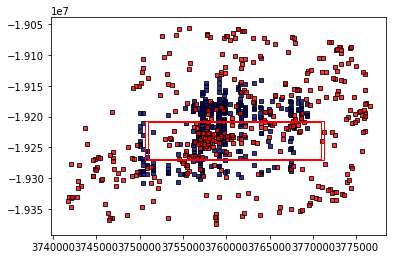

In [210]:
# accuracy 
y_test = np.array(y_test)
a = 350
bonus = [a,3*a]
print (classification_report(city(y_test,bonus=[0,0]), city(y_multiknn,bonus=bonus),digits = 6))
print (confusion_matrix(city(y_test,bonus=[0,0]), city(y_multiknn,bonus=bonus)))
print (accuracy_score(city(y_test,bonus=[0,0]), city(y_multiknn,bonus=bonus)))

# plotting 
plt.figure()
s = 20
a = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_multiknn[:, 0], y_multiknn[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
y_test = np.array(y_test)
ax.scatter(y_test[:, 0], y_test[:, 1], edgecolor='k',
            c="red", s=s, marker="s", alpha=a, label="Data")
rect1 = patches.Rectangle((3750901.5068,-19268905.6133),20000,60000,linewidth=1,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((3750901.5068-bonus[0],-19268905.6133-bonus[1]),20000+2*bonus[0],60000+2*bonus[1],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.show()

# decision tree

In [199]:
# not effective for large dataset
X_train_dt = pd.DataFrame(X_train_all.loc[0:2000])
y_train_dt = pd.DataFrame(y_train_all.loc[0:2000])
# spliting test/train data 
train_size = int(0.8*np.shape(X_train_dt)[0])
test_size = np.shape(X_train_dt)[0]-train_size
X_train, X_test, y_train, y_test = train_test_split(
    X_train_dt, y_train_dt, train_size=train_size, test_size=test_size, random_state=4)

# extra tree
regr_multidt = MultiOutputRegressor(DecisionTreeRegressor(random_state=0))
regr_multidt.fit(X_train, y_train)
# Predict on new data
y_multidt = regr_multiab.predict(X_test)

             precision    recall  f1-score   support

        0.0   0.783088  0.747368  0.764811       285
        1.0   0.441860  0.491379  0.465306       116

avg / total   0.684379  0.673317  0.678172       401

[[213  72]
 [ 59  57]]
0.6733167082294265


<Figure size 432x288 with 0 Axes>

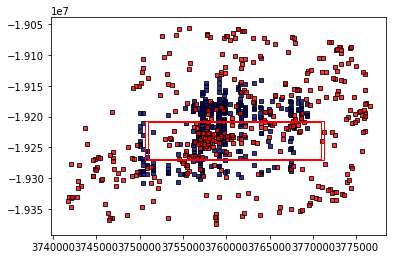

In [200]:
# accuracy 
y_test = np.array(y_test)
a = 350
bonus = [a,3*a]
print (classification_report(city(y_test,bonus=[0,0]), city(y_multidt,bonus=bonus),digits = 6))
print (confusion_matrix(city(y_test,bonus=[0,0]), city(y_multidt,bonus=bonus)))
print (accuracy_score(city(y_test,bonus=[0,0]), city(y_multidt,bonus=bonus)))

# plotting 
plt.figure()
s = 20
a = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_multidt[:, 0], y_multiab[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
y_test = np.array(y_test)
ax.scatter(y_test[:, 0], y_test[:, 1], edgecolor='k',
            c="red", s=s, marker="s", alpha=a, label="Data")
rect1 = patches.Rectangle((3750901.5068,-19268905.6133),20000,60000,linewidth=1,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((3750901.5068-bonus[0],-19268905.6133-bonus[1]),20000+2*bonus[0],60000+2*bonus[1],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.show()

# AdaBoostRegressor

In [201]:
# not effective for large dataset
X_train_ab = pd.DataFrame(X_train_all.loc[0:2000])
y_train_ab = pd.DataFrame(y_train_all.loc[0:2000])
# spliting test/train data 
train_size = int(0.8*np.shape(X_train_ab)[0])
test_size = np.shape(X_train_ab)[0]-train_size
X_train, X_test, y_train, y_test = train_test_split(
    X_train_ab, y_train_ab, train_size=train_size, test_size=test_size, random_state=4)

# extra tree
regr_multiab = MultiOutputRegressor(AdaBoostRegressor(n_estimators=200,random_state=0))
regr_multiab.fit(X_train, y_train)
# Predict on new data
y_multiab = regr_multiab.predict(X_test)

             precision    recall  f1-score   support

        0.0   0.783088  0.747368  0.764811       285
        1.0   0.441860  0.491379  0.465306       116

avg / total   0.684379  0.673317  0.678172       401

[[213  72]
 [ 59  57]]
0.6733167082294265


<Figure size 432x288 with 0 Axes>

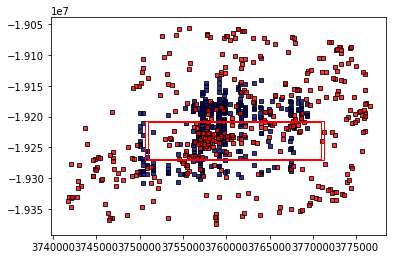

In [202]:
# accuracy 
y_test = np.array(y_test)
a = 350
bonus = [a,3*a]
print (classification_report(city(y_test,bonus=[0,0]), city(y_multiab,bonus=bonus),digits = 6))
print (confusion_matrix(city(y_test,bonus=[0,0]), city(y_multiab,bonus=bonus)))
print (accuracy_score(city(y_test,bonus=[0,0]), city(y_multiab,bonus=bonus)))

# plotting 
plt.figure()
s = 20
a = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_multiab[:, 0], y_multiab[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
y_test = np.array(y_test)
ax.scatter(y_test[:, 0], y_test[:, 1], edgecolor='k',
            c="red", s=s, marker="s", alpha=a, label="Data")
rect1 = patches.Rectangle((3750901.5068,-19268905.6133),20000,60000,linewidth=1,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((3750901.5068-bonus[0],-19268905.6133-bonus[1]),20000+2*bonus[0],60000+2*bonus[1],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.show()

# ExtraTreesRegressor

In [203]:
# not effective for large dataset
X_train_et = pd.DataFrame(X_train_all.loc[0:2000])
y_train_et = pd.DataFrame(y_train_all.loc[0:2000])
# spliting test/train data 
train_size = int(0.8*np.shape(X_train_et)[0])
test_size = np.shape(X_train_et)[0]-train_size
X_train, X_test, y_train, y_test = train_test_split(
    X_train_et, y_train_et, train_size=train_size, test_size=test_size, random_state=4)

# extra tree
regr_multiet = MultiOutputRegressor(ExtraTreesRegressor(n_estimators=200,max_depth=100,random_state=0,verbose=True))
regr_multiet.fit(X_train, y_train)
# Predict on new data
y_multiet = regr_multiet.predict(X_test)


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    8.5s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    8.4s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


             precision    recall  f1-score   support

        0.0   0.878543  0.761404  0.815789       285
        1.0   0.558442  0.741379  0.637037       116

avg / total   0.785945  0.755611  0.764081       401

[[217  68]
 [ 30  86]]
0.7556109725685786


<Figure size 432x288 with 0 Axes>

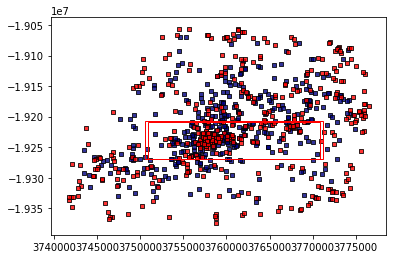

In [204]:
# accuracy 
y_test = np.array(y_test)
a = 350
bonus = [a,3*a]
print (classification_report(city(y_test,bonus=[0,0]), city(y_multiet,bonus=bonus),digits = 6))
print (confusion_matrix(city(y_test,bonus=[0,0]), city(y_multiet,bonus=bonus)))
print (accuracy_score(city(y_test,bonus=[0,0]), city(y_multiet,bonus=bonus)))

# plotting 
plt.figure()
s = 20
a = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_multiet[:, 0], y_multiet[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
y_test = np.array(y_test)
ax.scatter(y_test[:, 0], y_test[:, 1], edgecolor='k',
            c="red", s=s, marker="s", alpha=a, label="Data")
rect1 = patches.Rectangle((3750901.5068,-19268905.6133),20000,60000,linewidth=1,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((3750901.5068-bonus[0],-19268905.6133-bonus[1]),20000+2*bonus[0],60000+2*bonus[1],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.show()

# random forest

In [205]:
# not effective for large dataset
X_train_rf = pd.DataFrame(X_train_all.loc[0:2000])
y_train_rf = pd.DataFrame(y_train_all.loc[0:2000])
# spliting test/train data 
train_size = int(0.8*np.shape(X_train_rf)[0])
test_size = np.shape(X_train_rf)[0]-train_size
X_train, X_test, y_train, y_test = train_test_split(
    X_train_rf, y_train_rf, train_size=train_size, test_size=test_size, random_state=4)

# random forest
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=200,max_depth=100,random_state=0,verbose=True))
regr_multirf.fit(X_train, y_train)
# Predict on new data
y_multirf = regr_multirf.predict(X_test)

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   14.6s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   14.3s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


             precision    recall  f1-score   support

        0.0   0.916996  0.814035  0.862454       285
        1.0   0.641892  0.818966  0.719697       116

avg / total   0.837415  0.815461  0.821157       401

[[232  53]
 [ 21  95]]
0.8154613466334164


<Figure size 432x288 with 0 Axes>

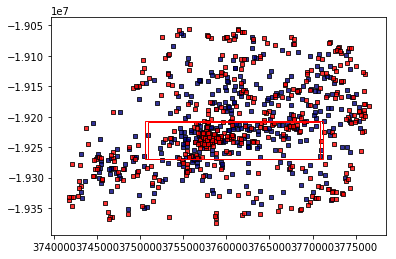

In [206]:
# accuracy 
y_test = np.array(y_test)
a = 350
bonus = [a,3*a]
print (classification_report(city(y_test,bonus=[0,0]), city(y_multirf,bonus=bonus),digits = 6))
print (confusion_matrix(city(y_test,bonus=[0,0]), city(y_multirf,bonus=bonus)))
print (accuracy_score(city(y_test,bonus=[0,0]), city(y_multirf,bonus=bonus)))

# plotting 
plt.figure()
s = 20
a = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_multirf[:, 0], y_multirf[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
y_test = np.array(y_test)
ax.scatter(y_test[:, 0], y_test[:, 1], edgecolor='k',
            c="red", s=s, marker="s", alpha=a, label="Data")
rect1 = patches.Rectangle((3750901.5068,-19268905.6133),20000,60000,linewidth=1,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((3750901.5068-bonus[0],-19268905.6133-bonus[1]),20000+2*bonus[0],60000+2*bonus[1],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.show()

In [201]:
result = pd.DataFrame(city(y_multirf))

hash_names = pd.DataFrame(pd.read_csv('data_test.csv'))
hash_names = hash_names[hash_names["x_exit"].isna()]["trajectory_id"]
hash_names = pd.DataFrame(hash_names).values.flatten()
hash_names = pd.DataFrame(hash_names)

results = pd.concat([hash_names, result],axis =1)
results.to_csv('Final_Results.csv')
results.head()

,0,0
0,traj_00032f51796fd5437b238e3a9823d13d_31_5,0.0
1,traj_000479418b5561ab694a2870cc04fd43_25_10,0.0
2,traj_000506a39775e5bca661ac80e3f466eb_29_5,1.0
3,traj_0005401ceddaf27a9b7f0d42ef1fbe95_1_4,0.0
4,traj_00063a4f6c12e1e4de7d876580620667_3_4,1.0


# gradient boosting

In [51]:
# 
X_train_gb = pd.DataFrame(X_train_all.loc[0:2000])
y_train_gb = pd.DataFrame(y_train_all.loc[0:2000])
# spliting test/train data 
train_size = int(0.8*np.shape(X_train_gb)[0])
test_size = np.shape(X_train_gb)[0]-train_size
X_train, X_test, y_train, y_test = train_test_split(
    X_train_gb, y_train_gb, train_size=train_size, test_size=test_size, random_state=4)

# gradient boosting 
regr_multigbr = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100,max_depth=20,random_state=0,verbose=True))
regr_multigbr.fit(X_train, y_train)
# Predict on new data
y_multigbr = regr_multigbr.predict(X_test)


      Iter       Train Loss   Remaining Time 
         1    71025569.4502           32.47s
         2    57559883.6862           31.92s
         3    46651060.4669           31.58s
         4    37814441.6113           31.19s
         5    30658227.9351           30.85s
         6    24851040.4915           30.62s
         7    20147208.4866           30.31s
         8    16327871.7629           30.10s
         9    13232220.7728           29.89s
        10    10725060.3338           29.62s
        20     1313869.5396           26.90s
        30      162783.3028           23.82s
        40       20099.5058           20.66s
        50        2483.7623           17.39s
        60         303.4997           14.13s
        70          37.1070           10.74s
        80           4.5163            7.24s
        90           0.5510            3.64s
       100           0.0671            0.00s
      Iter       Train Loss   Remaining Time 
         1  4897094325.0051           31.68s
        

             precision    recall  f1-score   support

        0.0     0.8781    0.8750    0.8766       280
        1.0     0.7131    0.7190    0.7160       121

avg / total     0.8283    0.8279    0.8281       401

[[245  35]
 [ 34  87]]
0.827930174563591


<Figure size 432x288 with 0 Axes>

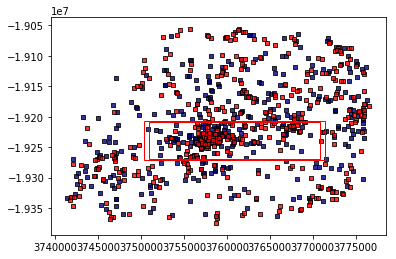

In [53]:
# accuracy 
y_test = np.array(y_test)
bonus = [500,2000]
print (classification_report(city(y_test), city(y_multigbr,bonus=bonus),digits = 4))
print (confusion_matrix(city(y_test), city(y_multigbr,bonus=bonus)))
print (accuracy_score(city(y_test), city(y_multigbr,bonus=bonus)))

# plotting 
plt.figure()
s = 20
a = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_multigbr[:, 0], y_multigbr[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
y_test = np.array(y_test)
ax.scatter(y_test[:, 0], y_test[:, 1], edgecolor='k',
            c="red", s=s, marker="s", alpha=a, label="Data")
rect1 = patches.Rectangle((3750901.5068,-19268905.6133),20000,60000,linewidth=1,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((3750901.5068-bonus[0],-19268905.6133-bonus[1]),20000+2*bonus[0],60000+2*bonus[1],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.show()

# minibatch SGDClassifier

In [54]:
X_train_SGD = pd.DataFrame(X_train_all)
y_train_SGD = pd.DataFrame(y_train_all)
# spliting test/train data 
train_size = int(0.8*np.shape(X_train_SGD)[0])
test_size = np.shape(X_train_SGD)[0]-train_size
X_train, X_test, y_train, y_test = train_test_split(
    X_train_SGD, y_train_SGD, train_size=train_size, test_size=test_size, random_state=4)

regr_SGD = linear_model.SGDClassifier(alpha=0.0001, average=False, class_weight=None,
        epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,verbose = True)

regr_SGD.fit(X_train, city(np.array(y_train),bonus=[500,2000]))
# Predict on new data
y_SGD = regr_SGD.predict(X_test)


-- Epoch 1
Norm: 28258140.63, NNZs: 195, Bias: -15.699984, T: 107250, Avg. loss: 388576975645039.562500
Total training time: 0.10 seconds.
-- Epoch 2
Norm: 22335077.67, NNZs: 195, Bias: -16.753925, T: 214500, Avg. loss: 57649609654288.218750
Total training time: 0.19 seconds.
-- Epoch 3
Norm: 20972886.03, NNZs: 195, Bias: -17.355067, T: 321750, Avg. loss: 33548032418371.246094
Total training time: 0.29 seconds.
-- Epoch 4
Norm: 20167176.19, NNZs: 195, Bias: -17.808277, T: 429000, Avg. loss: 24015209117569.921875
Total training time: 0.38 seconds.
-- Epoch 5
Norm: 19443785.79, NNZs: 195, Bias: -18.118896, T: 536250, Avg. loss: 18569055093519.371094
Total training time: 0.48 seconds.
-- Epoch 6
Norm: 19021531.82, NNZs: 195, Bias: -18.324384, T: 643500, Avg. loss: 15193495855522.837891
Total training time: 0.57 seconds.
-- Epoch 7
Norm: 18255715.32, NNZs: 195, Bias: -18.610623, T: 750750, Avg. loss: 12788336962428.253906
Total training time: 0.69 seconds.
-- Epoch 8
Norm: 17924730.12, NNZ

Norm: 9436424.89, NNZs: 195, Bias: -20.697001, T: 6542250, Avg. loss: 1365693824880.482666
Total training time: 6.51 seconds.
-- Epoch 62
Norm: 9351465.32, NNZs: 195, Bias: -20.706104, T: 6649500, Avg. loss: 1343180829426.559814
Total training time: 6.60 seconds.
-- Epoch 63
Norm: 9262286.87, NNZs: 195, Bias: -20.718023, T: 6756750, Avg. loss: 1325733745721.798828
Total training time: 6.70 seconds.
-- Epoch 64
Norm: 9182323.11, NNZs: 195, Bias: -20.723869, T: 6864000, Avg. loss: 1306058264445.156250
Total training time: 6.79 seconds.
-- Epoch 65
Norm: 9106801.19, NNZs: 195, Bias: -20.733984, T: 6971250, Avg. loss: 1289287932051.652100
Total training time: 6.88 seconds.
-- Epoch 66
Norm: 9012532.83, NNZs: 195, Bias: -20.741110, T: 7078500, Avg. loss: 1269610997200.012451
Total training time: 6.98 seconds.
-- Epoch 67
Norm: 8919733.28, NNZs: 195, Bias: -20.750925, T: 7185750, Avg. loss: 1252779983114.347168
Total training time: 7.07 seconds.
-- Epoch 68
Norm: 8843822.03, NNZs: 195, Bias:

Norm: 5930527.46, NNZs: 195, Bias: -21.049805, T: 12977250, Avg. loss: 694029960485.347656
Total training time: 12.51 seconds.
-- Epoch 122
Norm: 5881037.96, NNZs: 195, Bias: -21.053652, T: 13084500, Avg. loss: 684405596857.040894
Total training time: 12.61 seconds.
-- Epoch 123
Norm: 5830166.66, NNZs: 195, Bias: -21.057460, T: 13191750, Avg. loss: 678691547879.985718
Total training time: 12.70 seconds.
-- Epoch 124
Norm: 5789662.47, NNZs: 195, Bias: -21.061989, T: 13299000, Avg. loss: 673035612521.645386
Total training time: 12.80 seconds.
-- Epoch 125
Norm: 5744235.69, NNZs: 195, Bias: -21.064982, T: 13406250, Avg. loss: 666830866863.182129
Total training time: 12.89 seconds.
-- Epoch 126
Norm: 5702059.07, NNZs: 195, Bias: -21.067952, T: 13513500, Avg. loss: 664969424060.281616
Total training time: 12.98 seconds.
-- Epoch 127
Norm: 5673162.85, NNZs: 195, Bias: -21.072373, T: 13620750, Avg. loss: 659845463282.856689
Total training time: 13.07 seconds.
-- Epoch 128
Norm: 5639990.96, NN

Norm: 4296822.61, NNZs: 195, Bias: -21.241436, T: 19519500, Avg. loss: 455970310161.467957
Total training time: 18.56 seconds.
-- Epoch 183
Norm: 4282408.18, NNZs: 195, Bias: -21.243477, T: 19626750, Avg. loss: 454440768862.479736
Total training time: 18.66 seconds.
-- Epoch 184
Norm: 4264562.57, NNZs: 195, Bias: -21.247032, T: 19734000, Avg. loss: 450642229002.889832
Total training time: 18.76 seconds.
-- Epoch 185
Norm: 4253515.13, NNZs: 195, Bias: -21.249556, T: 19841250, Avg. loss: 451049531415.431091
Total training time: 18.86 seconds.
-- Epoch 186
Norm: 4235124.43, NNZs: 195, Bias: -21.252069, T: 19948500, Avg. loss: 448982783021.300598
Total training time: 18.95 seconds.
-- Epoch 187
Norm: 4216753.09, NNZs: 195, Bias: -21.254570, T: 20055750, Avg. loss: 442180724295.492615
Total training time: 19.05 seconds.
-- Epoch 188
Norm: 4199058.13, NNZs: 195, Bias: -21.257057, T: 20163000, Avg. loss: 440762686288.981934
Total training time: 19.14 seconds.
-- Epoch 189
Norm: 4179333.10, NN

Norm: 3417513.46, NNZs: 195, Bias: -21.377649, T: 25954500, Avg. loss: 345698609483.463257
Total training time: 24.67 seconds.
-- Epoch 243
Norm: 3405601.70, NNZs: 195, Bias: -21.379187, T: 26061750, Avg. loss: 341644283826.139832
Total training time: 24.76 seconds.
-- Epoch 244
Norm: 3394437.60, NNZs: 195, Bias: -21.381484, T: 26169000, Avg. loss: 342988921830.775146
Total training time: 24.86 seconds.
-- Epoch 245
Norm: 3384050.49, NNZs: 195, Bias: -21.383771, T: 26276250, Avg. loss: 337811776110.372925
Total training time: 24.96 seconds.
-- Epoch 246
Norm: 3375100.40, NNZs: 195, Bias: -21.385290, T: 26383500, Avg. loss: 339288121778.227295
Total training time: 25.05 seconds.
-- Epoch 247
Norm: 3365220.13, NNZs: 195, Bias: -21.387183, T: 26490750, Avg. loss: 336001511885.616638
Total training time: 25.14 seconds.
-- Epoch 248
Norm: 3355175.42, NNZs: 195, Bias: -21.389820, T: 26598000, Avg. loss: 337580435979.193054
Total training time: 25.24 seconds.
-- Epoch 249
Norm: 3342450.22, NN

Norm: 2860979.01, NNZs: 195, Bias: -21.484976, T: 32282250, Avg. loss: 276323232247.080383
Total training time: 30.27 seconds.
-- Epoch 302
Norm: 2851470.87, NNZs: 195, Bias: -21.487140, T: 32389500, Avg. loss: 273995365453.337433
Total training time: 30.36 seconds.
-- Epoch 303
Norm: 2846666.84, NNZs: 195, Bias: -21.488680, T: 32496750, Avg. loss: 274792737410.283997
Total training time: 30.45 seconds.
-- Epoch 304
Norm: 2840050.07, NNZs: 195, Bias: -21.489908, T: 32604000, Avg. loss: 271910061641.602875
Total training time: 30.55 seconds.
-- Epoch 305
Norm: 2830310.67, NNZs: 195, Bias: -21.491439, T: 32711250, Avg. loss: 271489547271.316589
Total training time: 30.66 seconds.
-- Epoch 306
Norm: 2821439.10, NNZs: 195, Bias: -21.492966, T: 32818500, Avg. loss: 273090365337.687958
Total training time: 30.77 seconds.
-- Epoch 307
Norm: 2818150.40, NNZs: 195, Bias: -21.495096, T: 32925750, Avg. loss: 270160548757.754364
Total training time: 30.88 seconds.
-- Epoch 308
Norm: 2807587.34, NN

Norm: 2471916.17, NNZs: 195, Bias: -21.572494, T: 38610000, Avg. loss: 229825520874.545349
Total training time: 36.91 seconds.
-- Epoch 361
Norm: 2467829.45, NNZs: 195, Bias: -21.574047, T: 38717250, Avg. loss: 229731763407.132385
Total training time: 37.01 seconds.
-- Epoch 362
Norm: 2461758.85, NNZs: 195, Bias: -21.575853, T: 38824500, Avg. loss: 229973316705.546448
Total training time: 37.11 seconds.
-- Epoch 363
Norm: 2455546.92, NNZs: 195, Bias: -21.577139, T: 38931750, Avg. loss: 231891453275.969757
Total training time: 37.21 seconds.
-- Epoch 364
Norm: 2452738.97, NNZs: 195, Bias: -21.577908, T: 39039000, Avg. loss: 228036262814.127563
Total training time: 37.31 seconds.
-- Epoch 365
Norm: 2445054.23, NNZs: 195, Bias: -21.579444, T: 39146250, Avg. loss: 226697528936.559296
Total training time: 37.41 seconds.
-- Epoch 366
Norm: 2438200.65, NNZs: 195, Bias: -21.580210, T: 39253500, Avg. loss: 227217718648.568726
Total training time: 37.50 seconds.
-- Epoch 367
Norm: 2434284.35, NN

Norm: 2174164.19, NNZs: 195, Bias: -21.649663, T: 45045000, Avg. loss: 197659950425.178619
Total training time: 42.88 seconds.
-- Epoch 421
Norm: 2167654.07, NNZs: 195, Bias: -21.650773, T: 45152250, Avg. loss: 197989626594.674438
Total training time: 43.00 seconds.
-- Epoch 422
Norm: 2163158.22, NNZs: 195, Bias: -21.651879, T: 45259500, Avg. loss: 196955695799.666229
Total training time: 43.12 seconds.
-- Epoch 423
Norm: 2158345.01, NNZs: 195, Bias: -21.653424, T: 45366750, Avg. loss: 197255102317.707489
Total training time: 43.25 seconds.
-- Epoch 424
Norm: 2152622.31, NNZs: 195, Bias: -21.654304, T: 45474000, Avg. loss: 195543890316.926575
Total training time: 43.37 seconds.
-- Epoch 425
Norm: 2147298.73, NNZs: 195, Bias: -21.654963, T: 45581250, Avg. loss: 195929520081.689697
Total training time: 43.50 seconds.
-- Epoch 426
Norm: 2143073.19, NNZs: 195, Bias: -21.656279, T: 45688500, Avg. loss: 195334243247.848480
Total training time: 43.62 seconds.
-- Epoch 427
Norm: 2141622.81, NN

Norm: 1945851.97, NNZs: 195, Bias: -21.717909, T: 51480000, Avg. loss: 173760541238.584625
Total training time: 49.50 seconds.
-- Epoch 481
Norm: 1943988.67, NNZs: 195, Bias: -21.718491, T: 51587250, Avg. loss: 172349542754.335114
Total training time: 49.59 seconds.
-- Epoch 482
Norm: 1940411.91, NNZs: 195, Bias: -21.719847, T: 51694500, Avg. loss: 173232066473.809570
Total training time: 49.69 seconds.
-- Epoch 483
Norm: 1937603.65, NNZs: 195, Bias: -21.720813, T: 51801750, Avg. loss: 170571149443.479645
Total training time: 49.79 seconds.
-- Epoch 484
Norm: 1933530.96, NNZs: 195, Bias: -21.721970, T: 51909000, Avg. loss: 171662959218.907410
Total training time: 49.88 seconds.
-- Epoch 485
Norm: 1931533.63, NNZs: 195, Bias: -21.723510, T: 52016250, Avg. loss: 170840656164.807892
Total training time: 49.97 seconds.
-- Epoch 486
Norm: 1927634.07, NNZs: 195, Bias: -21.724662, T: 52123500, Avg. loss: 171198206381.431244
Total training time: 50.06 seconds.
-- Epoch 487
Norm: 1923584.58, NN

Norm: 1763923.26, NNZs: 195, Bias: -21.775785, T: 57807750, Avg. loss: 153973814262.749359
Total training time: 54.96 seconds.
-- Epoch 540
Norm: 1762013.28, NNZs: 195, Bias: -21.776822, T: 57915000, Avg. loss: 154076914701.950775
Total training time: 55.05 seconds.
-- Epoch 541
Norm: 1757821.08, NNZs: 195, Bias: -21.777857, T: 58022250, Avg. loss: 154264603639.669769
Total training time: 55.15 seconds.
-- Epoch 542
Norm: 1754731.48, NNZs: 195, Bias: -21.778718, T: 58129500, Avg. loss: 153396272086.665985
Total training time: 55.24 seconds.
-- Epoch 543
Norm: 1753046.00, NNZs: 195, Bias: -21.780092, T: 58236750, Avg. loss: 153013788003.471375
Total training time: 55.33 seconds.
-- Epoch 544
Norm: 1750731.32, NNZs: 195, Bias: -21.780607, T: 58344000, Avg. loss: 152808560852.654327
Total training time: 55.42 seconds.
-- Epoch 545
Norm: 1747885.38, NNZs: 195, Bias: -21.781463, T: 58451250, Avg. loss: 152540504102.955383
Total training time: 55.52 seconds.
-- Epoch 546
Norm: 1745542.99, NN

Norm: 1616744.74, NNZs: 195, Bias: -21.828786, T: 64135500, Avg. loss: 139564882615.633392
Total training time: 60.64 seconds.
-- Epoch 599
Norm: 1614085.50, NNZs: 195, Bias: -21.829720, T: 64242750, Avg. loss: 138945299681.345062
Total training time: 60.76 seconds.
-- Epoch 600
Norm: 1612477.84, NNZs: 195, Bias: -21.830497, T: 64350000, Avg. loss: 138157783930.169189
Total training time: 60.85 seconds.
-- Epoch 601
Norm: 1609596.63, NNZs: 195, Bias: -21.831118, T: 64457250, Avg. loss: 136655900693.783234
Total training time: 60.94 seconds.
-- Epoch 602
Norm: 1608319.54, NNZs: 195, Bias: -21.832358, T: 64564500, Avg. loss: 137824687573.354095
Total training time: 61.04 seconds.
-- Epoch 603
Norm: 1605448.27, NNZs: 195, Bias: -21.832977, T: 64671750, Avg. loss: 138291739375.704803
Total training time: 61.13 seconds.
-- Epoch 604
Norm: 1603192.09, NNZs: 195, Bias: -21.833595, T: 64779000, Avg. loss: 137442798616.723572
Total training time: 61.22 seconds.
-- Epoch 605
Norm: 1601407.47, NN

Norm: 1491945.11, NNZs: 195, Bias: -21.877070, T: 70570500, Avg. loss: 126294023494.061646
Total training time: 67.08 seconds.
-- Epoch 659
Norm: 1491072.18, NNZs: 195, Bias: -21.877778, T: 70677750, Avg. loss: 125027456526.133896
Total training time: 67.17 seconds.
-- Epoch 660
Norm: 1488724.09, NNZs: 195, Bias: -21.878485, T: 70785000, Avg. loss: 125084529034.949020
Total training time: 67.26 seconds.
-- Epoch 661
Norm: 1486971.30, NNZs: 195, Bias: -21.879473, T: 70892250, Avg. loss: 125131624228.886307
Total training time: 67.35 seconds.
-- Epoch 662
Norm: 1485352.19, NNZs: 195, Bias: -21.880319, T: 70999500, Avg. loss: 125510911165.081665
Total training time: 67.45 seconds.
-- Epoch 663
Norm: 1483297.18, NNZs: 195, Bias: -21.881163, T: 71106750, Avg. loss: 125429393868.763474
Total training time: 67.54 seconds.
-- Epoch 664
Norm: 1479157.54, NNZs: 195, Bias: -21.881585, T: 71214000, Avg. loss: 125217397486.058578
Total training time: 67.63 seconds.
-- Epoch 665
Norm: 1476543.35, NN

Norm: 1381678.73, NNZs: 195, Bias: -21.921293, T: 77005500, Avg. loss: 115519221797.435303
Total training time: 73.34 seconds.
-- Epoch 719
Norm: 1380351.41, NNZs: 195, Bias: -21.922202, T: 77112750, Avg. loss: 115538814382.847839
Total training time: 73.44 seconds.
-- Epoch 720
Norm: 1377432.90, NNZs: 195, Bias: -21.922591, T: 77220000, Avg. loss: 115608507851.760895
Total training time: 73.53 seconds.
-- Epoch 721
Norm: 1375797.31, NNZs: 195, Bias: -21.923497, T: 77327250, Avg. loss: 115347190902.941238
Total training time: 73.62 seconds.
-- Epoch 722
Norm: 1374593.51, NNZs: 195, Bias: -21.924272, T: 77434500, Avg. loss: 114583103580.844101
Total training time: 73.71 seconds.
-- Epoch 723
Norm: 1371459.03, NNZs: 195, Bias: -21.925047, T: 77541750, Avg. loss: 115991153645.984207
Total training time: 73.81 seconds.
-- Epoch 724
Norm: 1369816.74, NNZs: 195, Bias: -21.925820, T: 77649000, Avg. loss: 114197006231.621445
Total training time: 73.90 seconds.
-- Epoch 725
Norm: 1367286.69, NN

Norm: 1288609.25, NNZs: 195, Bias: -21.963088, T: 83547750, Avg. loss: 107019846757.686829
Total training time: 79.57 seconds.
-- Epoch 780
Norm: 1284980.80, NNZs: 195, Bias: -21.963447, T: 83655000, Avg. loss: 106632016457.552582
Total training time: 79.67 seconds.
-- Epoch 781
Norm: 1283290.81, NNZs: 195, Bias: -21.964045, T: 83762250, Avg. loss: 106959458847.769943
Total training time: 79.78 seconds.
-- Epoch 782
Norm: 1282391.08, NNZs: 195, Bias: -21.964999, T: 83869500, Avg. loss: 105735913266.083466
Total training time: 79.90 seconds.
-- Epoch 783
Norm: 1280786.12, NNZs: 195, Bias: -21.965714, T: 83976750, Avg. loss: 106494470114.281921
Total training time: 80.03 seconds.
-- Epoch 784
Norm: 1279226.41, NNZs: 195, Bias: -21.966190, T: 84084000, Avg. loss: 106283996995.727402
Total training time: 80.16 seconds.
-- Epoch 785
Norm: 1276874.25, NNZs: 195, Bias: -21.966784, T: 84191250, Avg. loss: 106240153373.300049
Total training time: 80.29 seconds.
-- Epoch 786
Norm: 1275418.82, NN

Norm: 1207857.94, NNZs: 195, Bias: -22.000228, T: 89875500, Avg. loss: 98927836761.947021
Total training time: 85.74 seconds.
-- Epoch 839
Norm: 1206054.82, NNZs: 195, Bias: -22.000673, T: 89982750, Avg. loss: 98972180491.955139
Total training time: 85.86 seconds.
-- Epoch 840
Norm: 1204054.42, NNZs: 195, Bias: -22.001228, T: 90090000, Avg. loss: 99007954081.153000
Total training time: 85.98 seconds.
-- Epoch 841
Norm: 1202990.68, NNZs: 195, Bias: -22.002004, T: 90197250, Avg. loss: 98249639965.345642
Total training time: 86.11 seconds.
-- Epoch 842
Norm: 1201951.90, NNZs: 195, Bias: -22.002448, T: 90304500, Avg. loss: 98245807371.597321
Total training time: 86.23 seconds.
-- Epoch 843
Norm: 1201099.02, NNZs: 195, Bias: -22.003112, T: 90411750, Avg. loss: 98201009283.937637
Total training time: 86.35 seconds.
-- Epoch 844
Norm: 1200447.78, NNZs: 195, Bias: -22.003775, T: 90519000, Avg. loss: 98590306643.832352
Total training time: 86.47 seconds.
-- Epoch 845
Norm: 1197795.89, NNZs: 195

Norm: 1133386.13, NNZs: 195, Bias: -22.035127, T: 96417750, Avg. loss: 92863967691.066223
Total training time: 92.01 seconds.
-- Epoch 900
Norm: 1132772.48, NNZs: 195, Bias: -22.035853, T: 96525000, Avg. loss: 92808031364.069534
Total training time: 92.10 seconds.
-- Epoch 901
Norm: 1131358.34, NNZs: 195, Bias: -22.036163, T: 96632250, Avg. loss: 92181384252.061356
Total training time: 92.20 seconds.
-- Epoch 902
Norm: 1129906.55, NNZs: 195, Bias: -22.036887, T: 96739500, Avg. loss: 91521814302.657074
Total training time: 92.29 seconds.
-- Epoch 903
Norm: 1128901.27, NNZs: 195, Bias: -22.037507, T: 96846750, Avg. loss: 92259106560.975800
Total training time: 92.38 seconds.
-- Epoch 904
Norm: 1128652.46, NNZs: 195, Bias: -22.038023, T: 96954000, Avg. loss: 91941583875.556458
Total training time: 92.47 seconds.
-- Epoch 905
Norm: 1127411.20, NNZs: 195, Bias: -22.038642, T: 97061250, Avg. loss: 91356033468.325012
Total training time: 92.57 seconds.
-- Epoch 906
Norm: 1127647.38, NNZs: 195

Norm: 1078967.59, NNZs: 195, Bias: -22.068747, T: 102960000, Avg. loss: 86865763220.299881
Total training time: 98.31 seconds.
-- Epoch 961
Norm: 1078226.78, NNZs: 195, Bias: -22.069426, T: 103067250, Avg. loss: 86069353137.312302
Total training time: 98.40 seconds.
-- Epoch 962
Norm: 1077702.96, NNZs: 195, Bias: -22.069523, T: 103174500, Avg. loss: 86257668093.849060
Total training time: 98.50 seconds.
-- Epoch 963
Norm: 1076861.41, NNZs: 195, Bias: -22.070492, T: 103281750, Avg. loss: 86006640149.972137
Total training time: 98.59 seconds.
-- Epoch 964
Norm: 1075115.69, NNZs: 195, Bias: -22.070782, T: 103389000, Avg. loss: 86872171251.376282
Total training time: 98.71 seconds.
-- Epoch 965
Norm: 1074533.50, NNZs: 195, Bias: -22.071459, T: 103496250, Avg. loss: 86132025638.362717
Total training time: 98.83 seconds.
-- Epoch 966
Norm: 1074922.48, NNZs: 195, Bias: -22.072038, T: 103603500, Avg. loss: 85350149606.087723
Total training time: 98.95 seconds.
-- Epoch 967
Norm: 1073713.23, NN

In [58]:
# accuracy 
y_test = np.array(y_test)
print (classification_report(city(y_test), y_SGD,digits = 4))
print (confusion_matrix(city(y_test), y_SGD))
print (accuracy_score(city(y_test), y_SGD))
print(y_SGD[0:10])

/home/leung0222/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

        0.0     0.0000    0.0000    0.0000     19567
        1.0     0.2702    1.0000    0.4255      7246

avg / total     0.0730    0.2702    0.1150     26813

[[    0 19567]
 [    0  7246]]
0.2702420467683586
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


# chunks of ramdon forests

In [77]:
def generate_rf(X_train, y_train):
    rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=200,max_depth=100,random_state=0))
    rf.fit(X_train, y_train)
    return rf

def combine_rfs(rf_a, rf_b):
    rf_a.estimators_ += rf_b.estimators_
    rf_a.n_estimators = len(rf_a.estimators_)
    return rf_a

def fitting_by_chunks(X_train, y_train,num_rfs = 100):
    num_samples = len(y_train)
    # the less ramdom forests the better but slower  
    chunk_size = int(num_samples/num_rfs)
    #last_chunk = num_groups - chunk_size*num_iter
    
    X_train_rf = X_train[0:chunk_size]
    y_train_rf = y_train[0:chunk_size]
    rfs = generate_rf(X_train_rf, y_train_rf)

    for i in range(2,num_rfs+1):
        X_train_rf = X_train[(i-1)*chunk_size:i*chunk_size]
        y_train_rf = y_train[(i-1)*chunk_size:i*chunk_size]
        rf = generate_rf(X_train_rf, y_train_rf)
        rfs = combine_rfs(rfs,rf)

    #last chunk
    if num_samples != num_rfs*chunk_size:
        X_train = X_train[num_rfs*chunk_size:num_samples]
        y_train = y_train[num_rfs*chunk_size:num_samples]
        rf = generate_rf(X_train, y_train)
        rfs = combine_rfs(rfs,rf)
    
    return rfs


In [78]:
# not effective for large dataset
X_train_rfs = pd.DataFrame(X_train_all.loc[0:20000])
y_train_rfs = pd.DataFrame(y_train_all.loc[0:20000])
# spliting test/train data 
train_size = int(0.8*np.shape(X_train_rfs)[0])
test_size = np.shape(X_train_rfs)[0]-train_size
X_train, X_test, y_train, y_test = train_test_split(
    X_train_rfs, y_train_rfs, train_size=train_size, test_size=test_size, random_state=4)

rfs = fitting_by_chunks(X_train, y_train,num_rfs = 10)
y_multirfs = rfs.predict(X_test)

In [165]:
city_list = np.array([[]])
bonus = [500,2000]
for i in range (np.shape(y_multirfs)[0]):
    city = 0
    for j in range (1,np.shape(y_multirfs)[1]+1):
        y = np.array(y_multirfs[i][0:2*j])
        if y[0] > 3750901.5068-bonus[0] and y[0] < 3770901.5068+bonus[0] and y[1] > -19268905.6133-bonus[1] and y[1] < -19208905.6133+bonus[1]:
            city = city + 1
    if city > np.shape(y_multirfs)[1]/4:
        city_list = np.append(city_list,1)
    else:
        city_list = np.append(city_list,0)
# accuracy 
y_test = np.array(y_test)
city_list = np.array([city_list])
print (classification_report(city(y_test,bonus=[0,0]), city_list,digits = 4))
print (confusion_matrix(city(y_test,bonus=[0,0]), city_list))
print (accuracy_score(city(y_test,bonus=[0,0]), city_list))
          


TypeError: 'int' object is not callable

In [166]:
print(np.shape(city(y_test,bonus=[0,0])))
print(np.shape(city_list),np.shape(y_test),np.shape(y_multirfs),city_list[0:10],y_test[0:10])


TypeError: 'int' object is not callable

In [177]:
result = pd.DataFrame(city_list)

hash_names = pd.DataFrame(pd.read_csv('data_test.csv'))
hash_names = hash_names[hash_names["x_exit"].isna()]["trajectory_id"]
hash_names = pd.DataFrame(hash_names).values.flatten()
hash_names = pd.DataFrame(hash_names)

results = pd.concat([hash_names, result],axis =1)
results.to_csv('Final_Results.csv')
results.head()

,0,0
0,traj_00032f51796fd5437b238e3a9823d13d_31_5,0.0
1,traj_000479418b5561ab694a2870cc04fd43_25_10,0.0
2,traj_000506a39775e5bca661ac80e3f466eb_29_5,1.0
3,traj_0005401ceddaf27a9b7f0d42ef1fbe95_1_4,0.0
4,traj_00063a4f6c12e1e4de7d876580620667_3_4,0.0


In [196]:
for i in range (9):
    city = 0
    for j in range (1,np.shape(y_predict)[1]+1):
        y = np.array(y_predict[i][0:2*j])
        if y[0] > 3750901.5068 and y[0] < 3770901.5068 and y[1] > -19268905.6133 and y[1] < -19208905.6133:
            city = city + 1
print(city)

202


# final model

In [ ]:
X_test = pd.read_csv('X_test.csv',index_col=0)
X_test = pd.DataFrame(X_test)
y_predict = chosen_model.predict(X_test)
# downloading results
result = pd.DataFrame(city(y_predict))
result.to_csv('result.csv')

In [113]:
X_test = pd.read_csv('X_test.csv',index_col=0)
X_test = pd.DataFrame(X_test)
y_predict = regr_multigbr.predict(X_test)
# downloading results
result = pd.DataFrame(city(y_predict))

hash_names = pd.DataFrame(pd.read_csv('data_test.csv'))
hash_names = hash_names[hash_names["x_exit"].isna()]["trajectory_id"]
hash_names = pd.DataFrame(hash_names).values.flatten()
hash_names = pd.DataFrame(hash_names)

results = pd.concat([hash_names, result],axis =1)
results.to_csv('Final_Results.csv')
results.head()

,0,0
0,traj_00032f51796fd5437b238e3a9823d13d_31_5,0.0
1,traj_000479418b5561ab694a2870cc04fd43_25_10,0.0
2,traj_000506a39775e5bca661ac80e3f466eb_29_5,1.0
3,traj_0005401ceddaf27a9b7f0d42ef1fbe95_1_4,0.0
4,traj_00063a4f6c12e1e4de7d876580620667_3_4,0.0


array([0., 0., 0., 0., 0.])